In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py

from astropy.io import ascii, fits
from astropy.table import Table, join
from astropy.coordinates import SkyCoord
import astropy.units as u
import astropy.constants as cons
from astropy.visualization.wcsaxes import SphericalCircle

import scipy.integrate as integrate
from scipy.optimize import curve_fit

/home/elismar/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/elismar/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [3]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.3, Om0=0.27, Tcmb0=2.725)

[ 1.21154796e-05  4.39319909e-04 -2.11420409e-02  1.77834331e-01]


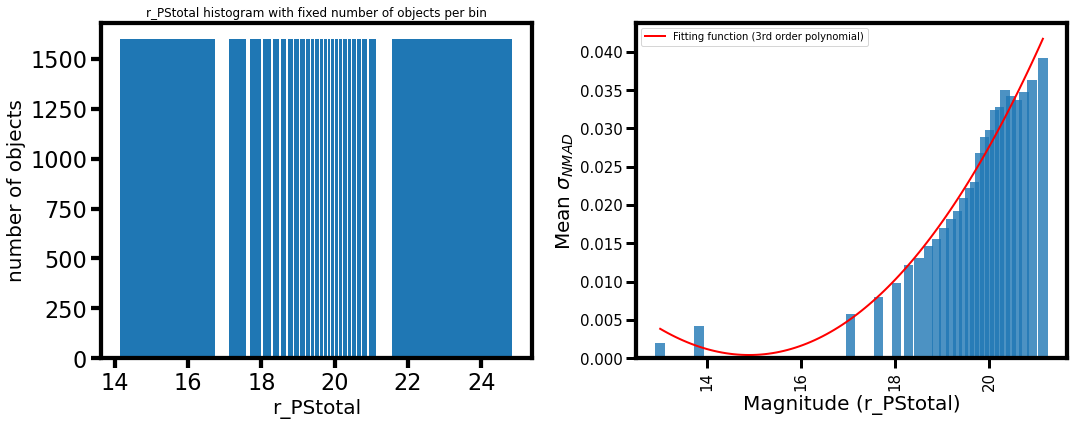

In [4]:
#Another way to do this would be to add an "__init__.py" to the folder '/work/Doc/galaxy-cluster-membership/' and import it as galaxy-cluster-membership.galaxy_cluster_membership I think
#See https://stackoverflow.com/questions/4383571/importing-files-from-different-folder
import sys
sys.path.insert(1, '/work/Doc/galaxy-cluster-membership/')
from galaxy_cluster_membership import *

In [5]:
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rc, rcParams
f = 0.8

fontsize = 30 * f
labelsize = 20 * f

rc("xtick", labelsize=fontsize * f)
rc("ytick", labelsize=fontsize * f)
rcParams["axes.linewidth"] = 5.3 * f
rcParams["xtick.major.width"] = 5.3 * f
rcParams["xtick.minor.width"] = 5.3 * f
rcParams["ytick.major.width"] = 5.3 * f
rcParams["ytick.minor.width"] = 5.3 * f
rcParams["xtick.major.size"] = 12.5 * f
rcParams["xtick.minor.size"] = 6.5 * f
rcParams["ytick.major.size"] = 12.5 * f
rcParams["ytick.minor.size"] = 6.5 * f

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 50 * f,
        }


cm1 = plt.cm.get_cmap('jet')
cm2 = plt.cm.get_cmap('rainbow')
cm3 = plt.cm.get_cmap('gnuplot2')

color_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
colors = [cm1(value) for value in color_values]

Coisas que o Pablito me passou:

 -  Dá pra usar o mock de boa. Os photo-zs não foram estimados do melhor jeito do mundo mas dá pra usar;
 - Eu falei de usar o mock que o Diego tá fazendo pro CHANCES, mas aquilo ainda vai demorar um tempo pra ficar pronto, e além disso eu tô aplicando esse método pra aglomerados do S-PLUS, então é melhor testar no mock do Pablo que foi feito pro S-PLUS
 - Ele falou de estimar o membership usando os photo-zs, e nesse caso simular as pdfs como gaussianas de largura ~0.005, mas na real eu acho que vou testar nos photo-zs mesmo;
 - Ao invés de estimar o raio do aglomerado no mock do jeito que eu tô fazendo atualmente, seria melhor pegar a massa M200 do aglomerado e estimar R200 a partir da relação
 
 $$ M_{200} = \frac{100 r_{200}^3 H^2(t)}{G} $$
 
fonte: Wikipedia

 - Essa massa tá disponível ali como a coluna "m_crit200", e a massa do aglomerado em si é a maior massa entre as subestruturas daquele halo.

### I have to identify some clusters in this mock in order to apply the membership over them
#### Start from here

In [6]:
hdul = fits.open("lightcone_zphot_subhalos_AllFrom1.fits")
scat = hdul[1].data

haloId = scat["haloId"]
galaxyId = scat["galaxyId"]
z_phot = scat["z_phot"]
z_spec = scat["z_app"]
ra = scat["RA"]
dec = scat["DEC"]
magr = scat["mag_r"]
firstHaloinFoFGroupId = scat["firstHaloinFoFGroupId"]

In [7]:
#I have to apply the mask "firstHaloinFoFGroupId > 0" because otherwise I will have the value -9223372036854775808
#in it, which is actually a value assumed by python for the galaxies with no firstHaloinFoFGroupId assigned to it

halo_members_list = []
for i in range(len(np.unique(firstHaloinFoFGroupId[firstHaloinFoFGroupId > 0]))):
    halo_members = np.sum(firstHaloinFoFGroupId == np.unique(firstHaloinFoFGroupId[firstHaloinFoFGroupId > 0])[i])
    halo_members_list.append(halo_members)

In [8]:
#To select the five more populated halos, I just need to do the following for the 
#last five elements of np.sort(halo_members_list)

#I am selecting the haloId of the cluster with the higher number of elements
#To select the five most populated cluster, I just need to apply i = 1, 2, 3, 4, 5

i = 1
halo_id = np.unique(firstHaloinFoFGroupId[firstHaloinFoFGroupId > 0])[halo_members_list == np.sort(halo_members_list)[-i]]
halo_mask = firstHaloinFoFGroupId == halo_id

halo_ra = ra[halo_mask]
halo_dec = dec[halo_mask]
halo_zphot = z_phot[halo_mask]
halo_zspec = z_spec[halo_mask]
halo_magr = magr[halo_mask]

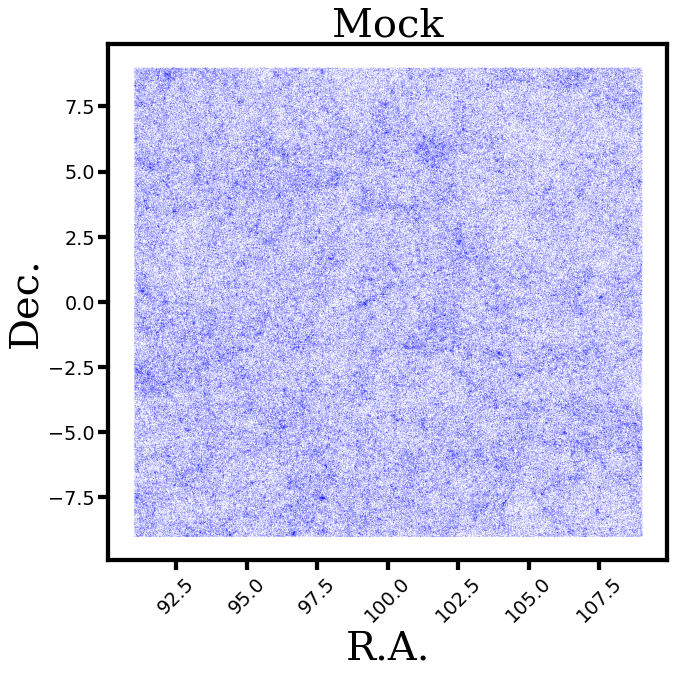

In [9]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

sc = ax.scatter(ra, dec, c="blue", s=0.0005)
ax.set_xlabel("R.A.", fontdict=font)
ax.set_ylabel("Dec.", fontdict=font)
ax.set_title("Mock", fontdict=font)

ax.tick_params(axis='x', rotation=45)
    
fig.tight_layout(pad=3.0)

Text(0, 0.5, 'Number of objects')

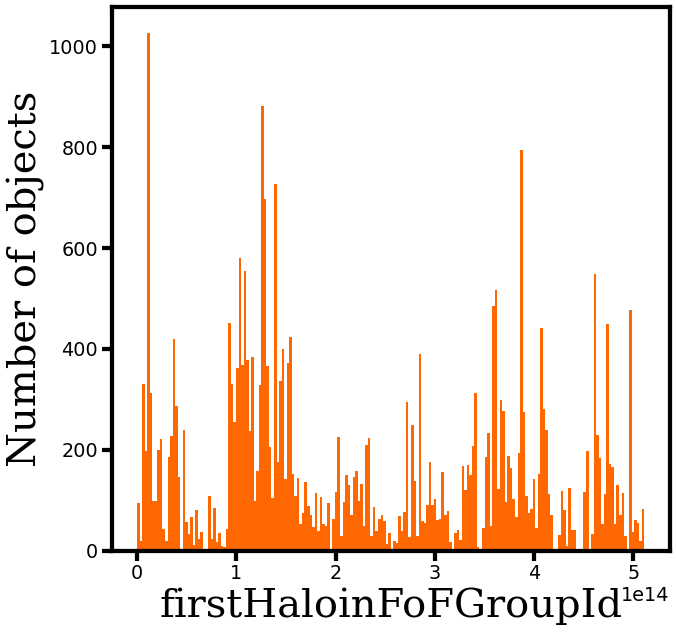

In [18]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

ax.hist(firstHaloinFoFGroupId[firstHaloinFoFGroupId > 0], bins=200, color=colors[7])[2]
ax.set_xlabel("firstHaloinFoFGroupId", fontdict=font)
ax.set_ylabel("Number of objects", fontdict=font)

### Defining properties of the cluster mock

In [10]:
#Define some quantities for the cluster (center cordinates, redshift, radius, photo-z error (sigma))
ra0 = np.mean(halo_ra)
dec0 = np.mean(halo_dec)

#Three possibilities to define the cluster redshift: mean, median or peak of the redshift distribution
mean_z = np.mean(halo_zspec)
median_z = np.median(halo_zspec)

z_bins = 30
i = np.argwhere(np.histogram(halo_zspec, bins=z_bins)[0] == np.histogram(halo_zspec, bins=z_bins)[0].max())[0][0]
z_peak = np.histogram(halo_zspec, bins=z_bins)[1][i]

z_cluster = z_peak

sigma_z = np.array([sigma_nmad(r) for r in magr])
sigma = np.median(sigma_z)
# z_lower = z_cluster-3*sigma
# z_upper = z_cluster+3*sigma

In [11]:
m200 = scat["m_crit200"][halo_mask].max() * 1e10 * u.Msun / cosmo.h

r200 = (m200 * cons.G / (100 * cosmo.H(z_cluster)**2))**(1/3)
r200_mpc = r200.to(u.Mpc)

kpc_scale = cosmo.kpc_proper_per_arcmin(z=z_cluster).value/60.
r200_deg = r200_mpc.value*1000 / (kpc_scale * 3600)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


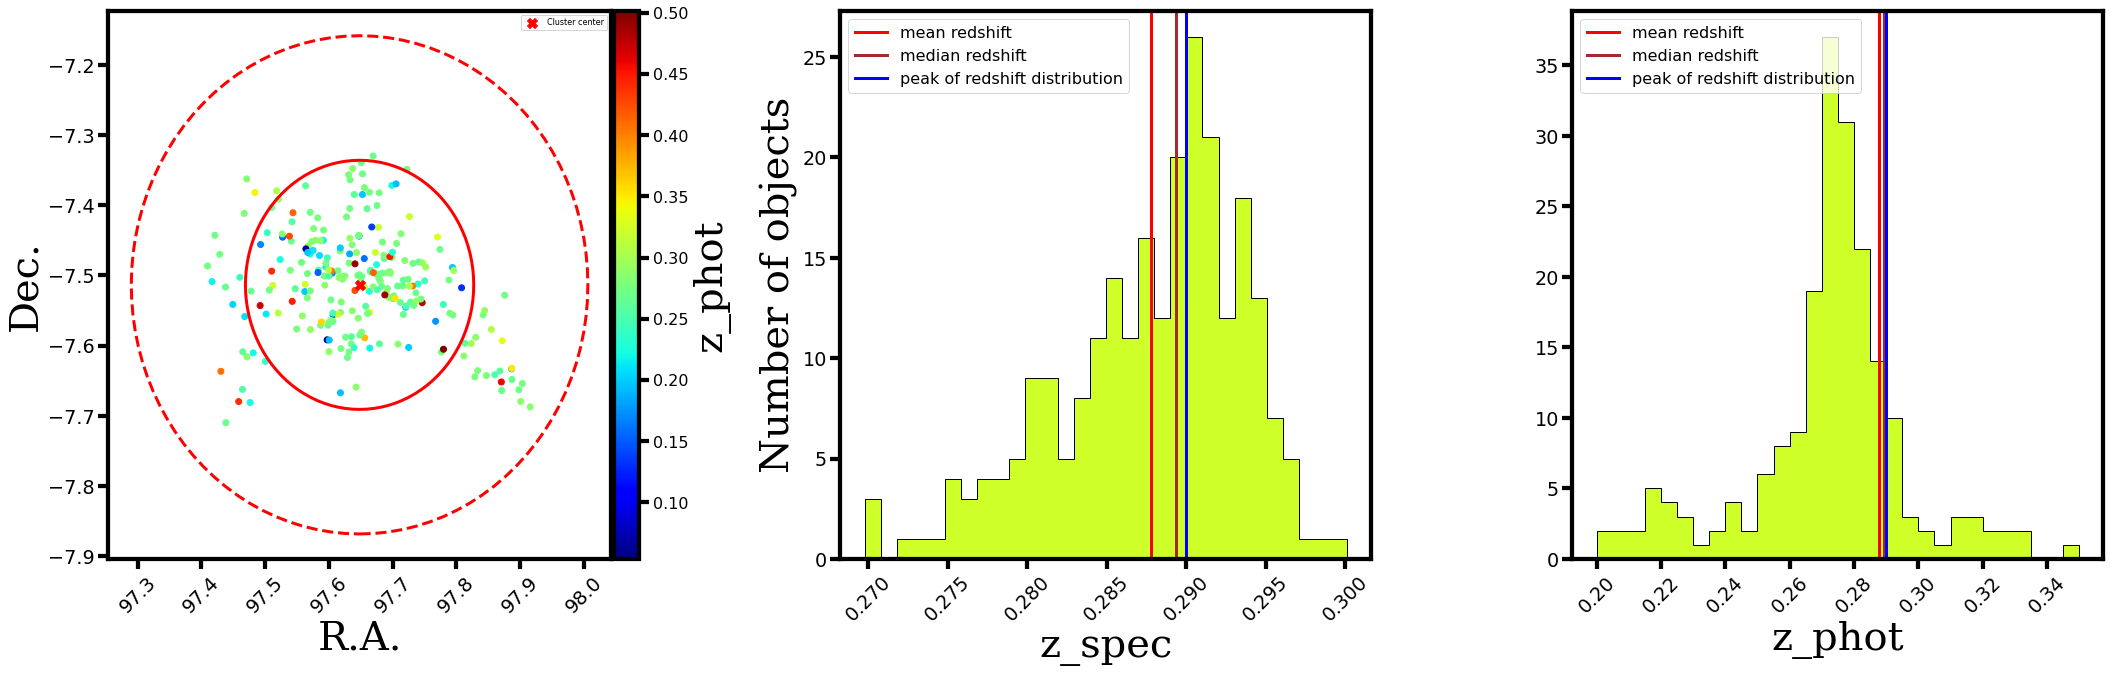

In [12]:
fig = plt.figure(figsize=(30, 10))


ax1 = fig.add_subplot(131)
sc = ax1.scatter(halo_ra, halo_dec, c=halo_zphot, cmap=cm1)
ax1.set_xlabel("R.A.", fontdict=font)
ax1.set_ylabel("Dec.", fontdict=font)

ax1.scatter(ra0, dec0, marker="X", s=100, color="red", label="Cluster center")
plt.legend(fontsize=labelsize*0.5)

ax1.tick_params(axis='x', rotation=45)

c0 = SkyCoord(ra=ra0, dec=dec0, frame='icrs', unit='deg')

r1 = SphericalCircle(c0, r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
ax1.add_patch(r1)

r2 = SphericalCircle(c0, 2*r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label=r"$2 \times$ Cluster radius", edgecolor="red", facecolor="None", ls='--')
ax1.add_patch(r2)


divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc, cax=cax1, orientation='vertical')
cbar.set_label(label="z_phot", fontdict=font)
cbar.ax.tick_params(labelsize=labelsize)

ax.legend(fontsize=labelsize)


ax2 = fig.add_subplot(132)
ax2.hist(halo_zspec, bins=z_bins, color=colors[5], histtype='stepfilled', edgecolor='k')[2]
ax2.set_xlabel("z_spec", fontdict=font)
ax2.set_ylabel("Number of objects", fontdict=font)
ax2.axvline(mean_z, color="red", lw=3, label="mean redshift")
ax2.axvline(median_z, color="brown", lw=3, label="median redshift")
ax2.axvline(z_cluster, color="blue", lw=3, label="peak of redshift distribution")
ax2.tick_params(axis='x', rotation=45)
ax2.legend(fontsize=labelsize)


ax3 = fig.add_subplot(133)
ax3.hist(halo_zphot, bins=z_bins, color=colors[5], histtype='stepfilled', edgecolor='k', range=(0.2, 0.35))[2]
ax3.set_xlabel("z_phot", fontdict=font)
# ax3.set_ylabel("Number of objects", fontdict=font)
ax3.axvline(mean_z, color="red", lw=3, label="mean redshift")
ax3.axvline(median_z, color="brown", lw=3, label="median redshift")
ax3.axvline(z_cluster, color="blue", lw=3, label="peak of redshift distribution")
ax3.tick_params(axis='x', rotation=45)
ax3.legend(fontsize=labelsize)
    
    
fig.tight_layout(pad=3.0)

I just defined the center and the redshift of the cluster, i.e., the center is given by mean of RA and DEC positions of galaxies in the clister (halo), and the redshift is the mean value of spectroscopic redshifts of galaxies in the cluster (maybe we could consider the median, but it it very similar to the mean). <br>

Next step is to get all field galaxies in the region of the cluster. I am thinking of doing it by considering a circular region of the cluster with a radius equals to the larger distance between a galaxy in the cluster an the center of the cluster. Then the field galaxies will be all galaxies distancing less than this radius from the center of the cluster.

In [13]:
#Computing the distance between all galaxies that I know are not in the cluster and the center of the cluster
dist_field = clustercentric_distance(ra[~halo_mask], dec[~halo_mask], ra0, dec0)

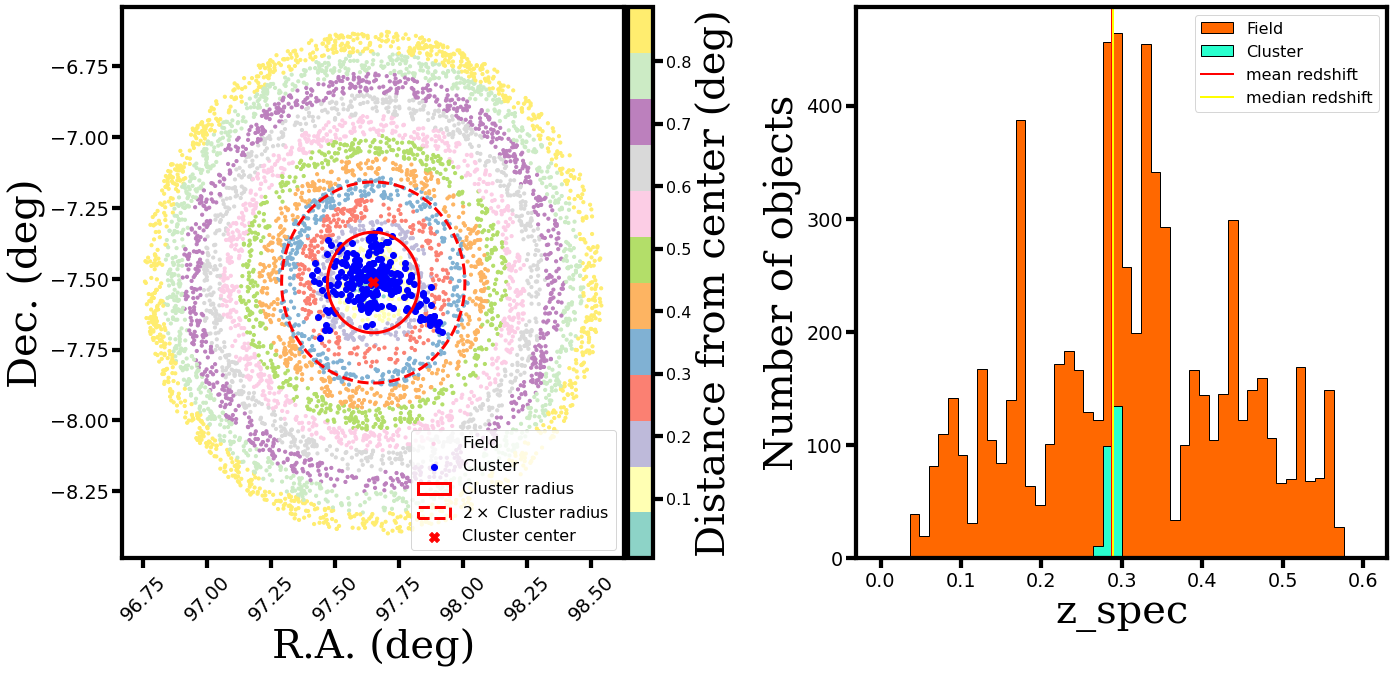

In [14]:
fig = plt.figure(figsize=(20, 10))


ax1 = fig.add_subplot(121)
max_dist = 5*r200_deg
sc = ax1.scatter(ra[~halo_mask][dist_field < max_dist], dec[~halo_mask][dist_field < max_dist], 
                c=dist_field[dist_field < max_dist], cmap=cm.Set3, s=10, label="Field")

sc2 = ax1.scatter(halo_ra, halo_dec, c="blue", label="Cluster")

c0 = SkyCoord(ra=ra0, dec=dec0, frame='icrs', unit='deg')

r1 = SphericalCircle(c0, r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
ax1.add_patch(r1)

r2 = SphericalCircle(c0, 2*r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label=r"$2 \times$ Cluster radius", edgecolor="red", facecolor="None", ls='--')
ax1.add_patch(r2)

ax1.set_xlabel("R.A. (deg)", fontdict=font)
ax1.set_ylabel("Dec. (deg)", fontdict=font)

ax1.scatter(ra0, dec0, marker="X", s=100, color="red", label="Cluster center")
plt.legend(fontsize=labelsize*0.5)

ax1.tick_params(axis='x', rotation=45)

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc, cax=cax1, orientation='vertical')
cbar.set_label(label="Distance from center (deg)", fontdict=font)
cbar.ax.tick_params(labelsize=labelsize)

ax1.legend(fontsize=labelsize)



max_z = 0.6
ax2 = fig.add_subplot(122)

ax2.hist(z_spec[~halo_mask][dist_field < max_dist], bins=50, 
        color=colors[7], histtype='stepfilled', edgecolor='k', range=[0, max_z], label="Field")[2]

ax2.hist(halo_zspec, bins=50, color=colors[3], histtype='stepfilled', edgecolor='k',
        range=[0, max_z], label="Cluster")[2]

ax2.set_xlabel("z_spec", fontdict=font)
ax2.set_ylabel("Number of objects", fontdict=font)

ax2.axvline(mean_z, color="red", lw=2, label="mean redshift")
ax2.axvline(median_z, color="yellow", lw=2, label="median redshift")
ax2.legend(fontsize=labelsize)


fig.tight_layout(pad=3.0)

### Start of the membership procedure
What I did until this point was: <br>
i) Defined the galaxies belonging to a cluster <br>
ii) Defined center of the cluster and its redshift <br>
iii) Defined the field galaxies <br>

Now, I have to test the membership in these cluster mocks without supposing anything about them, i.e., I will just take a region representing the cluster and apply the membership over it. The goal is to recover the galaxies that we know belong to the cluster. <br>

I have to think how I will compute the priors for these mock clusters.
For the real cluster, the priors were computed by estimating the number of field galaxies as the number of galaxies
in a region between 3 and 5 radius_cluster (the virial radius of the cluster) and with a photo-z out of a range
of 5*sigma from the cluster redshift. 
For the cluster mocks I can do something similar, but instead of taking the region between 3 and 5 radius_cluster,
I can consider a lower range of radii, since I now that all galaxies beyond radius_cluster here are field galaxies

In [15]:
dist = clustercentric_distance(ra, dec, ra0, dec0)

In [16]:
sigma_z = np.array([sigma_nmad(r) for r in magr])

#Define the volume of the cluster
#fz determines the extent in photo-z, and fr defines the extend in radius
fz = 3.0
fr = 5.0

#This mask defines all galaxies in the 5R200 projected area of the cluster
mask_cluster_region = dist < fr*r200_deg

#This one restricts the above mask to only the galaxies delimited by +/-fz*sigma from the cluster redshift, defining a list of candidate members
#mask_cluster = mask_cluster_region & (z_phot > z_cluster - fz*sigma_z*(1+z_cluster)) & (z_phot < z_cluster + fz*sigma_z*(1+z_cluster))

#This sigma_specz I apply to define the cluster's gaussian width in the membership method I think
sigma_z_cluster = np.array([sigma_nmad(r) for r in magr[mask_cluster_region]])
sigma = np.median(sigma_z_cluster)

### Compute priors

In [17]:
z_lower = 0.27
z_upper = 0.3

z_members, id_members = sigma_clipping(z_spec[mask_cluster_region], galaxyId[mask_cluster_region], z_lower, z_upper, 3.0)
mask_members = np.isin(galaxyId[mask_cluster_region], id_members)

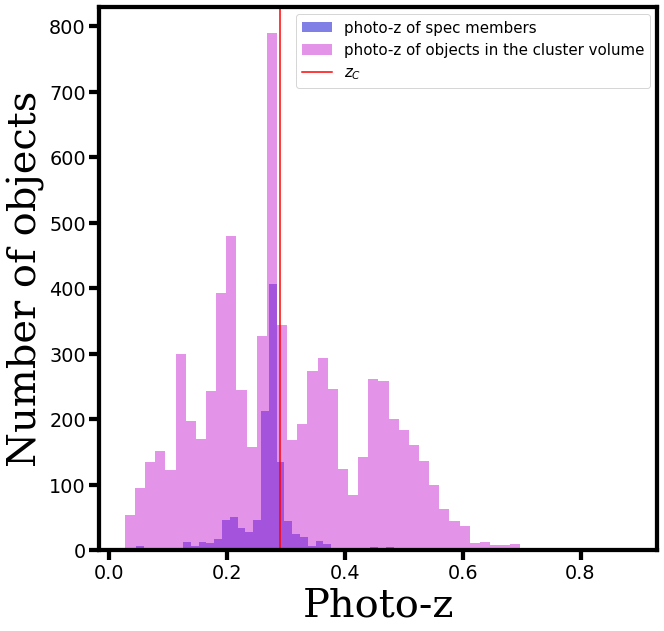

In [18]:
bins = 50
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)
ax1.hist(z_phot[mask_cluster_region][mask_members], bins=bins, histtype='stepfilled', 
         color=colors3[1], alpha=0.5, label="photo-z of spec members")
ax1.hist(z_phot[mask_cluster_region], bins=bins, histtype='stepfilled', 
         color=colors3[4], alpha=0.5, label="photo-z of objects in the cluster volume")
ax1.set_xlabel("Photo-z", fontdict=font)
ax1.set_ylabel("Number of objects", fontdict=font)
ax1.axvline(z_cluster, color="red", label=r"$z_C$")
ax1.legend(fontsize=15)

In [19]:
P_ginC = np.sum(mask_members) / np.sum(mask_cluster)
P_ginF = 1 - P_ginC

print("P (g in C) = {:.3f}".format(P_ginC))
print("P (g in F) = {:.3f}".format(P_ginF))

P (g in C) = 0.305
P (g in F) = 0.695


#### Now I can apply the final step of the membership procedure. 
The only problem is that we don't have photo-z PDFs in the mock, so I will have to do it in the same way as I done to the other mock, i.e., assume the PDFs are gaussian functions.

In [22]:
def P_pz(i, zc, zps, rmag, sigma):
    
    '''
    Perform the membership of galaxies in a cluster
    
    i : iterator over all galaxies in which the membership will be applied
    
    zagl : redshift of the cluster
    
    zphot : photometric redshift of the galaxies in which the membership will be applied
    
    rmag : r-band magnitude of the galaxies in which the membership will be applied
    '''

    #The ideia here is to normalize both the PDF and the Gaussian representing the cluster  
    def pdf(x, z, sigma):
        y = lambda x, z, sigma: (1 / (sigma * np.sqrt(2* np.pi))) * np.exp(-(x - z)**2 / (2*sigma**2)) 
        a = 1 / integrate.quad(y, 0.0, np.inf, args=(z, sigma))[0]
        return a * y(x, z, sigma)
        
    #This sigma here should be the median of sigma_nmads of galaxies in the cluster region
    def gaussian(x, zagl, sigma):
        y = lambda x, zagl, sigma: (1 / (sigma * np.sqrt(2* np.pi))) * np.exp(-(x - zagl)**2 / (2*sigma**2)) 
        a = 1 / integrate.quad(y, 0.0, np.inf, args=(zagl, sigma))[0]
        return a * y(x, zagl, sigma)
    
     
    P_pz_C_array = np.zeros(len(zps))
    P_pz_F_array = np.zeros(len(zps))
    for i in range(len(zps)):  
        z = zps[i]    
        
        if zagl - 3*sigma <= 0:
            P_pz_G = integrate.quad(lambda x, z, sigma, zagl: pdf(x, z, sigma) * gaussian(x, zagl, sigma), 0.0, zagl + 3*sigma, args=(z, sigma, zagl))[0] 
            P_pz_F = integrate.quad(lambda x, z, sigma: pdf(x, z, sigma) / (6*sigma), 0.0, zagl + 3*sigma, args=(z, sigma))[0]

        if zagl - 3*sigma > 0:
            P_pz_G = integrate.quad(lambda x, z, sigma, zagl: pdf(x, z, sigma) * gaussian(x, zagl, sigma), zagl - 3*sigma, zagl + 3*sigma, args=(z, sigma, zagl))[0] 
            P_pz_F = integrate.quad(lambda x, z, sigma: pdf(x, z, sigma) / (6*sigma), zagl - 3*sigma, zagl + 3*sigma, args=(z, sigma))[0]
        
    return P_pz_G, P_pz_F

In [20]:
def P_pz_george11_mock(zc, zps, rmag, sigma, fz):
    
    '''
    Perform the membership of galaxies in a cluster
    
    zc : redshift of the cluster
    
    zps : photometric redshift of the galaxies in which the membership will be applied
    
    rmag : r-band magnitude of the galaxies in which the membership will be applied
    '''

    sigma_array = np.array([sigma_nmad(r) for r in rmag])
    
    #The ideia here is to normalize both the PDF and the Gaussian representing the cluster  
    def pdf(x, z, sigma):
        y = lambda x, z, sigma: (1 / (sigma * np.sqrt(2* np.pi))) * np.exp(-(x - z)**2 / (2*sigma**2)) 
        a = 1 / integrate.quad(y, 0.0, np.inf, args=(z, sigma))[0]
        return a * y(x, z, sigma)
        
    #This sigma here should be the median of sigma_nmads of galaxies in the cluster region
    def gaussian(x, zc, sigma):
        y = lambda x, zc, sigma: (1 / (sigma * np.sqrt(2* np.pi))) * np.exp(-(x - zc)**2 / (2*sigma**2)) 
        a = 1 / integrate.quad(y, 0.0, np.inf, args=(zc, sigma))[0]
        return a * y(x, zc, sigma)
    
    
    #o sigma_i é o sigma_nmad de cada galáxia individualmente, e é usada para determinar a PDF das galáxias no mock
    #o sigma, que é uma das entradas da função, é a largura da guassiana que representa o aglomerado e entra também nos limites de integração
    
    P_pz_C_array = np.zeros(len(zps))
    P_pz_F_array = np.zeros(len(zps))
    for i in range(len(zps)):  
        z = zps[i]
        sigma_i = sigma_array[i]

        if zc - fz*sigma <= 0:
            P_pz_C = integrate.quad(lambda x, z, sigma_i, sigma, zc: pdf(x, z, sigma_i) * gaussian(x, zc, sigma), 0.0, zc + fz*sigma, args=(z, sigma_i, sigma, zc))[0] 
            P_pz_F = integrate.quad(lambda x, z, sigma_i, sigma: pdf(x, z, sigma_i) / (2*fz*sigma), 0.0, zc + fz*sigma, args=(z, sigma_i, sigma))[0]

        if zc - fz*sigma > 0:
            P_pz_C = integrate.quad(lambda x, z, sigma_i, sigma, zc: pdf(x, z, sigma_i) * gaussian(x, zc, sigma), zc - fz*sigma, zc + fz*sigma, args=(z, sigma_i, sigma, zc))[0] 
            P_pz_F = integrate.quad(lambda x, z, sigma_i, sigma: pdf(x, z, sigma_i) / (2*fz*sigma), zc - fz*sigma, zc + fz*sigma, args=(z, sigma_i, sigma))[0]
            
        P_pz_C_array[i] = P_pz_C
        P_pz_F_array[i] = P_pz_F

    return P_pz_C_array, P_pz_F_array

In [21]:
P_pz_C_array, P_pz_F_array = P_pz_george11_mock(z_cluster, z_phot[mask_cluster_region], magr[mask_cluster_region], sigma=sigma, fz=fz)

Pmem = (P_pz_C_array * P_ginC) / (P_pz_C_array * P_ginC + P_pz_F_array * P_ginF)

/tmp/ipykernel_3752/2421642958.py:3: RuntimeWarning: invalid value encountered in true_divide
  Pmem = (P_pz_C_array * P_ginC) / (P_pz_C_array * P_ginC + P_pz_F_array * P_ginF)


### Compute purity and completeness

In [22]:
completeness = []
purity = []
d = 0.01
Pmem_cut_arr = np.arange(0.0, 1.0, d)

for Pmem_cut in Pmem_cut_arr:
    
    c = np.sum(np.isin(galaxyId[halo_mask], galaxyId[mask_cluster_region][Pmem > Pmem_cut])) / len(galaxyId[halo_mask])
    p = np.sum(np.isin(galaxyId[mask_cluster_region][Pmem > Pmem_cut], galaxyId[halo_mask])) / len(galaxyId[mask_cluster_region][Pmem > Pmem_cut])
    
    completeness.append(c)
    purity.append(p)

/tmp/ipykernel_3752/736252314.py:9: RuntimeWarning: invalid value encountered in long_scalars
  p = np.sum(np.isin(galaxyId[mask_cluster_region][Pmem > Pmem_cut], galaxyId[halo_mask])) / len(galaxyId[mask_cluster_region][Pmem > Pmem_cut])


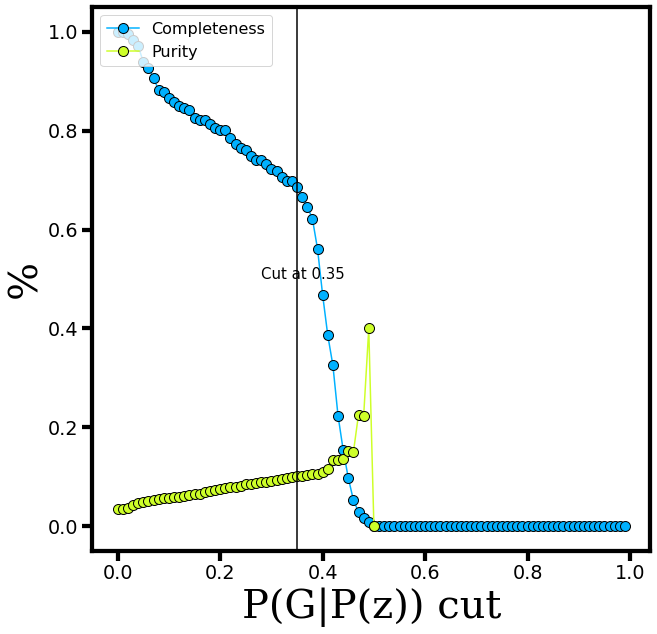

In [23]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)

ms = 10
ax1.plot(Pmem_cut_arr, completeness, marker='o', color=colors[2],
         label="Completeness", markersize=ms, markeredgecolor="black")
ax1.plot(Pmem_cut_arr, purity, marker='o', color=colors[5], 
         label="Purity", markersize=ms, markeredgecolor="black")
# ax1.plot(purity, completeness, marker='o', color=colors[5],
#          label="Completeness", markersize=ms, markeredgecolor="black")


ax1.set_ylabel("%", fontdict=font)
ax1.set_xlabel("P(G|P(z)) cut", fontdict=font)

cut = 0.35
ax1.axvline(cut, color="black")
ax1.text(x=cut-0.07, y=0.5, s="Cut at {:.2f}".format(cut), fontsize=15)

# c_best = 0.65
# ax1.axhline(c_best, color="black", linestyle="dashed")
# ax1.text(0.65, y=c_best+0.01, s="{:.2f}".format(c_best), fontsize=15)

# p_best = 0.41
# ax1.axhline(p_best, color="black", linestyle="dashed")
# ax1.text(0.65, y=p_best+0.01, s="{:.2f}".format(p_best), fontsize=15)

ax1.legend(fontsize=labelsize, loc=2)

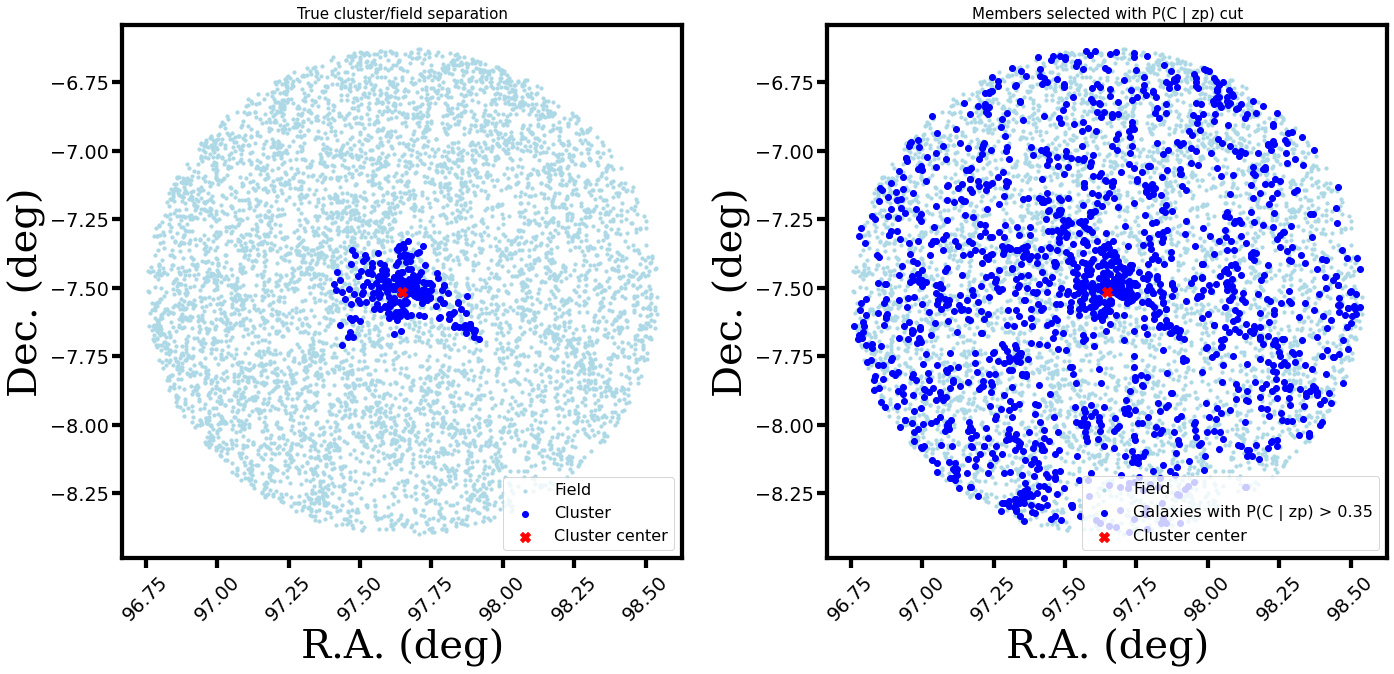

In [25]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(ra[~halo_mask][dist_field < max_dist], dec[~halo_mask][dist_field < max_dist], 
                c="lightblue", s=10, label="Field")
ax1.scatter(halo_ra, halo_dec, c="blue", label="Cluster")
ax1.set_title("True cluster/field separation", fontsize=15)
ax1.set_xlabel("R.A. (deg)", fontdict=font)
ax1.set_ylabel("Dec. (deg)", fontdict=font)
ax1.scatter(ra0, dec0, marker="X", s=100, color="red", label="Cluster center")
ax1.legend(fontsize=labelsize)
ax1.tick_params(axis='x', rotation=45)


ax2.scatter(ra[~halo_mask][dist_field < max_dist], dec[~halo_mask][dist_field < max_dist], 
                c="lightblue", s=10, label="Field")
ax2.scatter(ra[mask_cluster_region][Pmem > cut], dec[mask_cluster_region][Pmem > cut], c="blue", 
                label="Galaxies with P(C | zp) > {:.2f}".format(cut))
ax2.set_title("Members selected with P(C | zp) cut", fontsize=15)
ax2.set_xlabel("R.A. (deg)", fontdict=font)
ax2.set_ylabel("Dec. (deg)", fontdict=font)
ax2.scatter(ra0, dec0, marker="X", s=100, color="red", label="Cluster center")
ax2.legend(fontsize=labelsize)
ax2.tick_params(axis='x', rotation=45)

    
fig.tight_layout(pad=3.0)

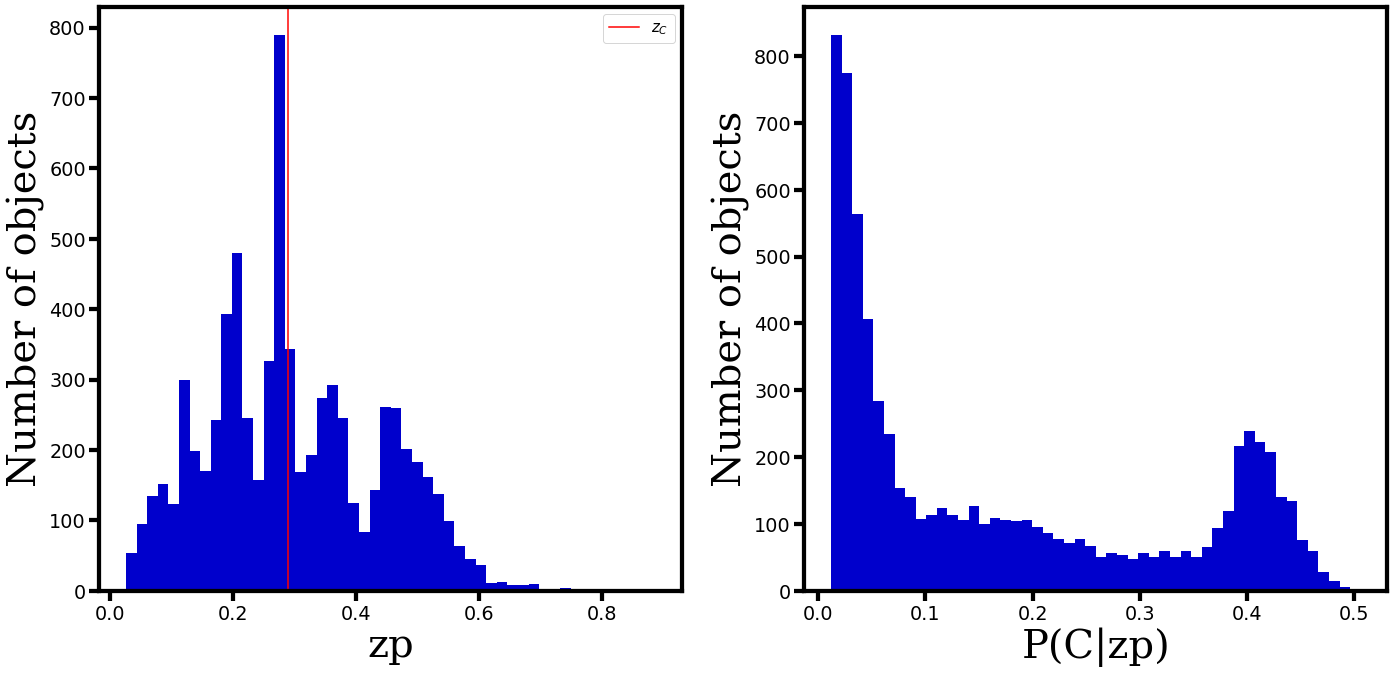

In [27]:
bins = 50
fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(121)
ax1.hist(z_phot[mask_cluster_region], bins=bins, histtype='stepfilled', 
         color=colors3[1], alpha=1.0)
ax1.set_xlabel("zp", fontdict=font)
ax1.set_ylabel("Number of objects", fontdict=font)
ax1.axvline(z_cluster, color="red", label=r"$z_C$")
ax1.legend(fontsize=15)

ax1 = fig.add_subplot(122)
ax1.hist(Pmem, bins=bins, histtype='stepfilled', 
         color=colors3[1], alpha=1.0)
ax1.set_xlabel("P(C|zp)", fontdict=font)
ax1.set_ylabel("Number of objects", fontdict=font)

fig.tight_layout(pad=3.0)

### Comparing the selection using $\sigma_{NMAD}$ cut with the probabilistic method (using photo-z PDFs)

In [135]:
completeness_alpha = []
purity_alpha = []

fz_array = np.arange(1.0, 5.5, 0.5)

for fz in fz_array:
    mask_cluster = mask_cluster_region & (z_phot > z_cluster - fz*sigma_z*(1+z_cluster)) & (z_phot < z_cluster + fz*sigma_z*(1+z_cluster))
    
    c = np.sum(np.isin(galaxyId[halo_mask], galaxyId[mask_cluster])) / len(galaxyId[halo_mask])
    p = np.sum(np.isin(galaxyId[mask_cluster], galaxyId[halo_mask])) / len(galaxyId[mask_cluster])
    
    completeness_alpha.append(c)
    purity_alpha.append(p)

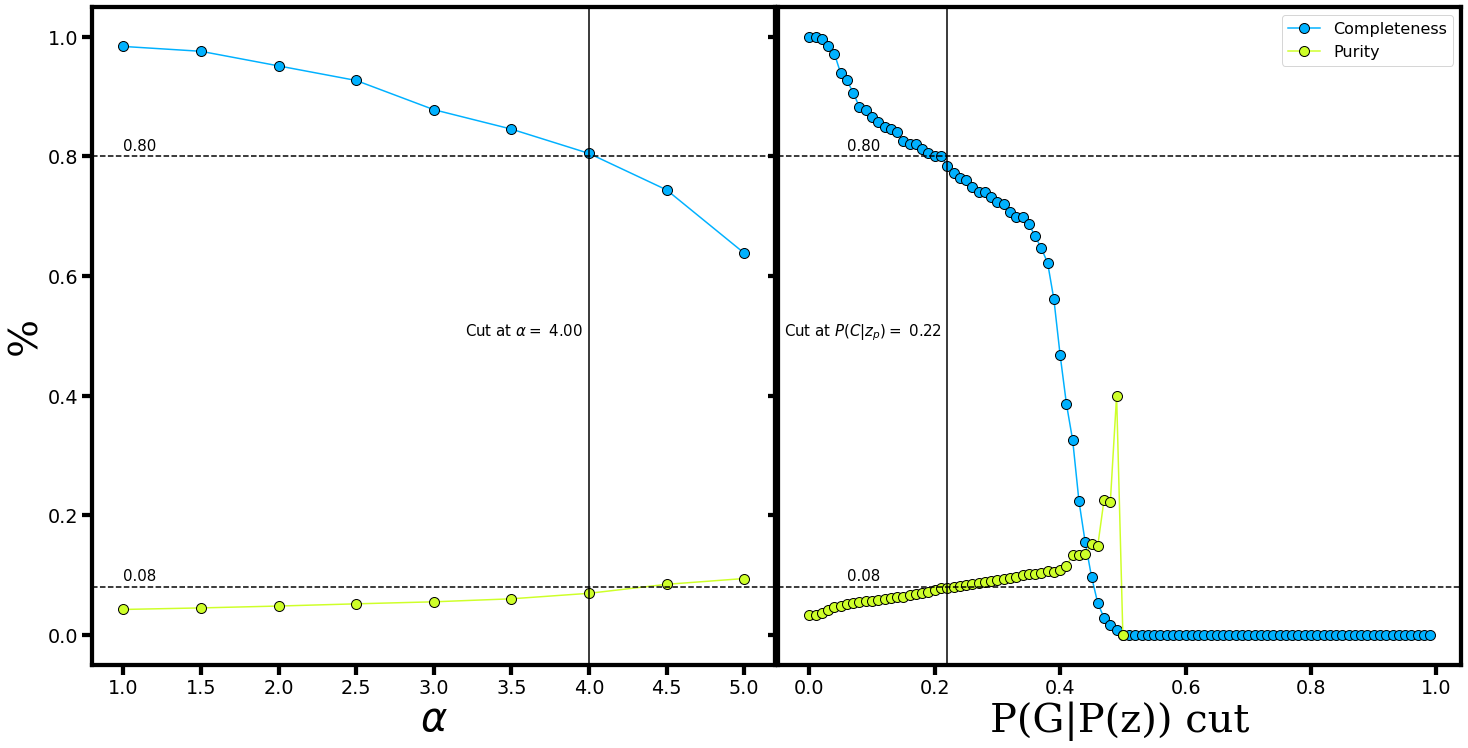

In [175]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharey=True)
ms = 10

ax1 = axs[0]
ax1.plot(np.flip(fz_array), completeness_alpha, marker='o', color=colors[2],label="Completeness", markersize=ms, markeredgecolor="black")
ax1.plot(np.flip(fz_array), purity_alpha, marker='o', color=colors[5], label="Purity", markersize=ms, markeredgecolor="black")
ax1.set_ylabel("%", fontdict=font)
ax1.set_xlabel(r"$\alpha$", fontdict=font)

c_best = 0.80
ax1.axhline(c_best, color="black", linestyle="dashed")
ax1.text(1.0, y=c_best+0.01, s="{:.2f}".format(c_best), fontsize=15)

p_best = 0.08
ax1.axhline(p_best, color="black", linestyle="dashed")
ax1.text(1.0, y=p_best+0.01, s="{:.2f}".format(p_best), fontsize=15)

cut_alpha = 4.0
ax1.axvline(cut_alpha, color="black")
ax1.text(x=cut_alpha-0.8, y=0.5, s=r"Cut at $\alpha =$ {:.2f}".format(cut_alpha), fontsize=15)


ax2 = axs[1]
ax2.plot(Pmem_cut_arr, completeness, marker='o', color=colors[2], label="Completeness", markersize=ms, markeredgecolor="black")
ax2.plot(Pmem_cut_arr, purity, marker='o', color=colors[5], label="Purity", markersize=ms, markeredgecolor="black")
ax2.set_xlabel("P(G|P(z)) cut", fontdict=font)
ax2.legend(fontsize=labelsize, loc=1)

cut = 0.22
ax2.axvline(cut, color="black")
ax2.text(x=cut-0.26, y=0.5, s=r"Cut at $P(C|z_p) =$ {:.2f}".format(cut), fontsize=15)

ax2.axhline(c_best, color="black", linestyle="dashed")
ax2.text(0.06, y=c_best+0.01, s="{:.2f}".format(c_best), fontsize=15)

ax2.axhline(p_best, color="black", linestyle="dashed")
ax2.text(0.06, y=p_best+0.01, s="{:.2f}".format(p_best), fontsize=15)


fig.tight_layout(pad=-0.7)

### Radial probabilities

In [28]:
mask_cluster = Pmem > 0.35

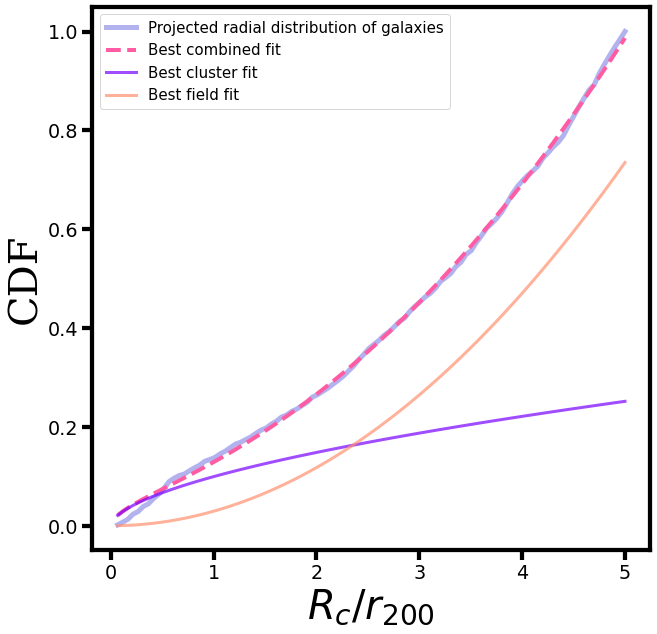

In [36]:
Pmem_R_C, Pmem_R_F = radial_mem_prob(dist[mask_cluster_region][mask_cluster], rc=r200_deg, plot=True)

In [37]:
completeness = []
purity = []
d = 0.01
Pmem_cut_arr = np.arange(0.0, 1.0, d)

for Pmem_cut in Pmem_cut_arr:
    
    c = np.sum(np.isin(galaxyId[halo_mask], galaxyId[mask_cluster_region][mask_cluster][Pmem_R_C > Pmem_cut])) / len(galaxyId[halo_mask])
    p = np.sum(np.isin(galaxyId[mask_cluster_region][mask_cluster][Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(galaxyId[mask_cluster_region][mask_cluster][Pmem_R_C > Pmem_cut])
    
    completeness.append(c)
    purity.append(p)

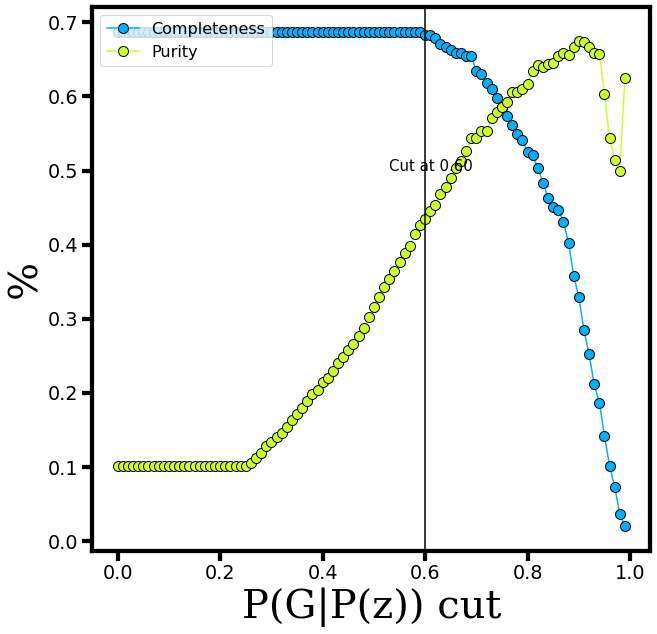

In [46]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)

ms = 10
ax1.plot(Pmem_cut_arr, completeness, marker='o', color=colors[2],
         label="Completeness", markersize=ms, markeredgecolor="black")
ax1.plot(Pmem_cut_arr, purity, marker='o', color=colors[5], 
         label="Purity", markersize=ms, markeredgecolor="black")


ax1.set_ylabel("%", fontdict=font)
ax1.set_xlabel("P(G|P(z)) cut", fontdict=font)

cut = 0.6
ax1.axvline(cut, color="black")
ax1.text(x=cut-0.07, y=0.5, s="Cut at {:.2f}".format(cut), fontsize=15)


ax1.legend(fontsize=labelsize, loc=2)

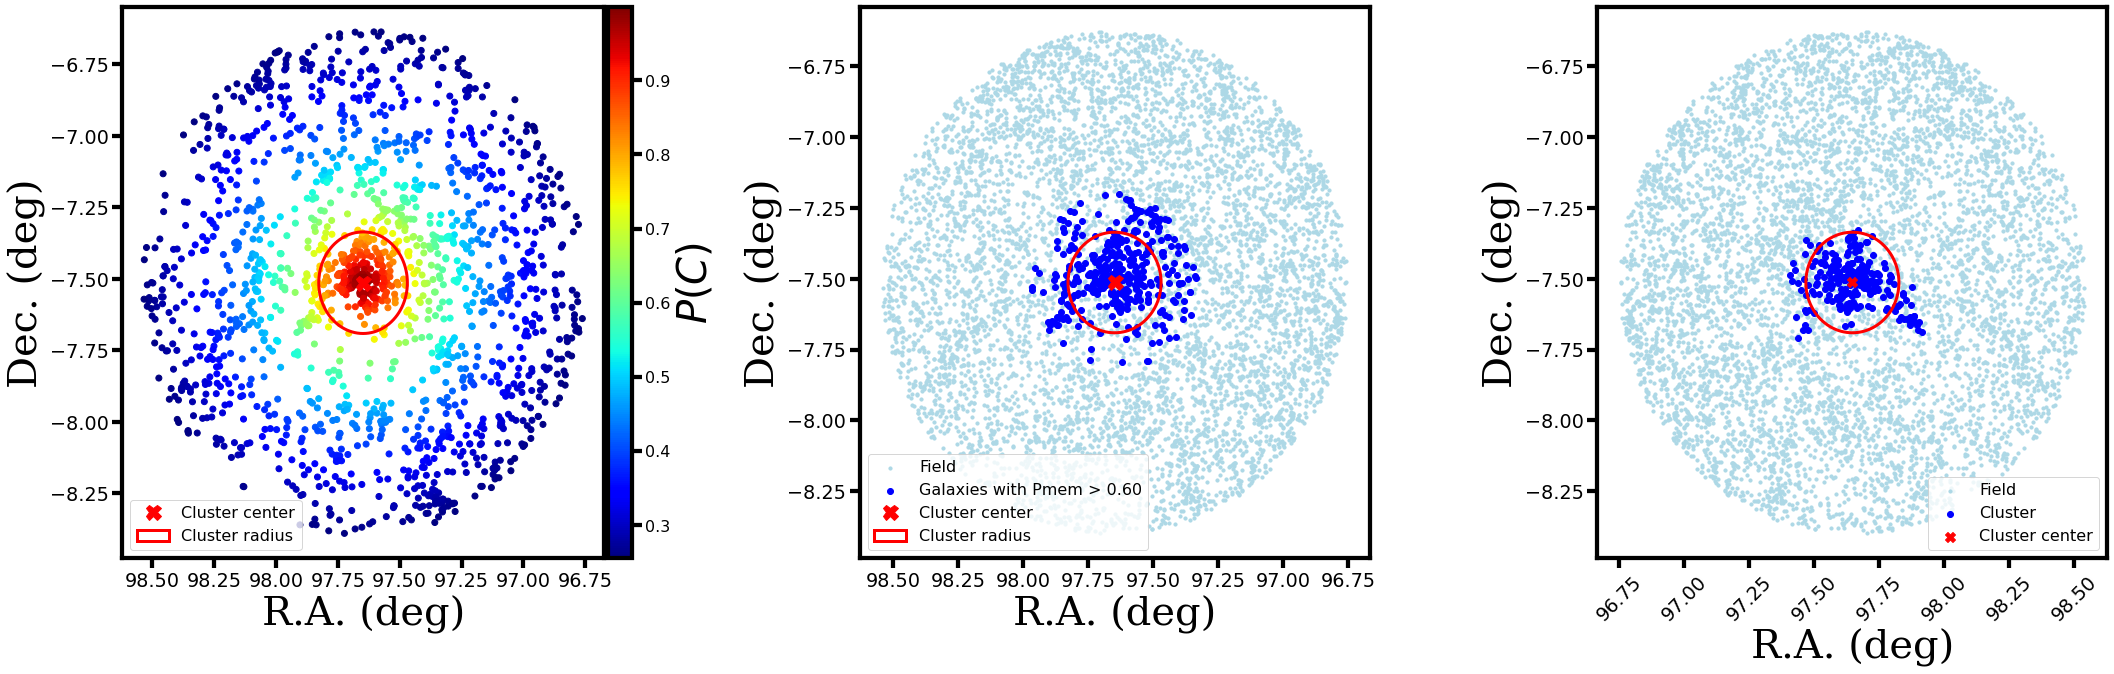

In [47]:
fig = plt.figure(figsize=(30, 10))


ax1 = fig.add_subplot(131)
sc1 = ax1.scatter(ra[mask_cluster_region][mask_cluster], dec[mask_cluster_region][mask_cluster], 
                  marker='o', c=Pmem_R_C, cmap="jet", rasterized=True)
ax1.plot(ra0, dec0, 'X', color="red", markersize=15, label="Cluster center")
ax1.set_xlabel("R.A. (deg)", fontdict=font)
ax1.set_ylabel("Dec. (deg)", fontdict=font)
ax1.invert_xaxis()
# ax1.set_title(cl_names[cluster], fontdict=font)

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label=r"$P(C)$", fontdict=font)
cbar.ax.tick_params(labelsize=labelsize)

r1 = SphericalCircle(c0, r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
ax1.add_patch(r1)
ax1.legend(fontsize=labelsize)



ax2 = fig.add_subplot(132)
ax2.scatter(ra[~halo_mask][dist_field < max_dist], dec[~halo_mask][dist_field < max_dist], c="lightblue", s=10, label="Field")
sc2 = ax2.scatter(ra[mask_cluster_region][mask_cluster][Pmem_R_C > cut], dec[mask_cluster_region][mask_cluster][Pmem_R_C > cut],
                  marker='o', c="blue", rasterized=True, label="Galaxies with Pmem > {:.2f}".format(cut))
ax2.plot(ra0, dec0, 'X', color="red", markersize=15, label="Cluster center")
ax2.set_xlabel("R.A. (deg)", fontdict=font)
ax2.set_ylabel("Dec. (deg)", fontdict=font)
ax2.invert_xaxis()

r1 = SphericalCircle(c0, r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
ax2.add_patch(r1)
ax2.legend(fontsize=labelsize)



ax3 = fig.add_subplot(133)
ax3.scatter(ra[~halo_mask][dist_field < max_dist], dec[~halo_mask][dist_field < max_dist], 
                c="lightblue", s=10, label="Field")
ax3.scatter(halo_ra, halo_dec, c="blue", label="Cluster")
ax3.set_xlabel("R.A. (deg)", fontdict=font)
ax3.set_ylabel("Dec. (deg)", fontdict=font)
ax3.scatter(ra0, dec0, marker="X", s=100, color="red", label="Cluster center")
ax3.legend(fontsize=labelsize)
ax3.tick_params(axis='x', rotation=45)

r1 = SphericalCircle(c0, r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
ax3.add_patch(r1)


fig.tight_layout(pad=3.0)

# plt.savefig("../figures/clusters-membership/RA_DEC_z_distribution_{}.png".format(cl_names[cluster]), dpi='figure', format='png')